In [47]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import rank, sum, col
from pyspark.sql.functions import mean, round
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline




In [6]:
spark = SparkSession.builder \
     .master("local[*]") \
     .appName("Home_Credit_Default_Risk") \
     .config("spark.some.config.option", "some-value") \
     .getOrCreate()

## Reading Dataset

In [7]:
new_df = spark.read.csv("/content/drive/My Drive/Big Data Project/application_train.csv", header=True)
new_df.show(5)


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-----------------+-----------------+-----------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-

In [8]:
new_df.count()

307511

In [9]:
len(new_df.columns)

122

In [10]:
new_df.head()

Row(SK_ID_CURR='100002', TARGET='1', NAME_CONTRACT_TYPE='Cash loans', CODE_GENDER='M', FLAG_OWN_CAR='N', FLAG_OWN_REALTY='Y', CNT_CHILDREN='0', AMT_INCOME_TOTAL='202500', AMT_CREDIT='406597.5', AMT_ANNUITY='24700.5', AMT_GOODS_PRICE='351000', NAME_TYPE_SUITE='Unaccompanied', NAME_INCOME_TYPE='Working', NAME_EDUCATION_TYPE='Secondary / secondary special', NAME_FAMILY_STATUS='Single / not married', NAME_HOUSING_TYPE='House / apartment', REGION_POPULATION_RELATIVE='0.018801', DAYS_BIRTH='-9461', DAYS_EMPLOYED='-637', DAYS_REGISTRATION='-3648', DAYS_ID_PUBLISH='-2120', OWN_CAR_AGE=None, FLAG_MOBIL='1', FLAG_EMP_PHONE='1', FLAG_WORK_PHONE='0', FLAG_CONT_MOBILE='1', FLAG_PHONE='1', FLAG_EMAIL='0', OCCUPATION_TYPE='Laborers', CNT_FAM_MEMBERS='1', REGION_RATING_CLIENT='2', REGION_RATING_CLIENT_W_CITY='2', WEEKDAY_APPR_PROCESS_START='WEDNESDAY', HOUR_APPR_PROCESS_START='10', REG_REGION_NOT_LIVE_REGION='0', REG_REGION_NOT_WORK_REGION='0', LIVE_REGION_NOT_WORK_REGION='0', REG_CITY_NOT_LIVE_CITY='

In [11]:
new_df.show(5)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-----------------+-----------------+-----------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-

In [12]:
#checking Nan's value
new_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in new_df.columns)).show()


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+----

## printing column

In [13]:
new_df.printSchema()

root
 |-- SK_ID_CURR: string (nullable = true)
 |-- TARGET: string (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: string (nullable = true)
 |-- AMT_INCOME_TOTAL: string (nullable = true)
 |-- AMT_CREDIT: string (nullable = true)
 |-- AMT_ANNUITY: string (nullable = true)
 |-- AMT_GOODS_PRICE: string (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: string (nullable = true)
 |-- DAYS_BIRTH: string (nullable = true)
 |-- DAYS_EMPLOYED: string (nullable = true)
 |-- DAYS_REGISTRATION: string (nullable = true)
 |-- DAYS_ID_PUBLISH: string (nullable = true)
 |-- OWN_CAR_AGE: str

## Reducing column and Changing column name

In [14]:
drop_col = ['SK_ID_CURR']

new_df = new_df.select([column for column in new_df.columns if column not in drop_col])

new_df = new_df.withColumnRenamed('TARGET', 'label')
new_df.groupby('label').count().toPandas()

,label,count
0,0,282686
1,1,24825


## printing in pandas dataframe

In [15]:
# let's see how everything look in Pandas
pd.DataFrame(new_df.take(10), columns= new_df.columns)


,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500,406597.5,24700.5,351000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648,-2120,None,1,1,0,1,1,0,Laborers,1,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,...,0.0205,0.0193,0,0,reg oper account,block of flats,0.0149,"Stone, brick",No,2,2,2,2,-1134,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,Cash loans,F,N,N,0,270000,1293502.5,35698.5,1129500,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186,-291,None,1,1,0,1,1,0,Core staff,2,1,1,MONDAY,11,0,0,0,0,0,0,School,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1,0,1,0,-828,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,Revolving loans,M,Y,Y,0,67500,135000,6750,135000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260,-2531,26,1,1,1,1,1,0,Laborers,1,2,2,MONDAY,9,0,0,0,0,0,0,Government,...,None,None,None,None,None,None,None,None,None,0,0,0,0,-815,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,Cash loans,F,N,Y,0,135000,312682.5,29686.5,297000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833,-2437,None,1,1,0,1,0,0,Laborers,2,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,...,None,None,None,None,None,None,None,None,None,2,0,2,0,-617,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None,None,None,None,None
4,0,Cash loans,M,N,Y,0,121500,513000,21865.5,513000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311,-3458,None,1,1,0,1,0,0,Core staff,1,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,...,None,None,None,None,None,None,None,None,None,0,0,0,0,-1106,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,Cash loans,M,N,Y,0,99000,490495.5,27517.5,454500,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970,-477,None,1,1,1,1,1,0,Laborers,2,2,2,WEDNESDAY,16,0,0,0,0,0,0,Other,...,None,None,None,None,None,None,None,None,None,0,0,0,0,-2536,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6,0,Cash loans,F,Y,Y,1,171000,1560726,41301,1395000,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130,-1213,-619,17,1,1,0,1,1,0,Accountants,3,2,2,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,...,None,None,None,None,None,None,None,None,None,1,0,1

## Changing datatype of the column

In [16]:
new_df = new_df.withColumn("label", new_df["label"].cast(IntegerType()))
new_df = new_df.withColumn("CNT_CHILDREN", new_df["CNT_CHILDREN"].cast(IntegerType()))
new_df = new_df.withColumn("AMT_INCOME_TOTAL", new_df["AMT_INCOME_TOTAL"].cast(IntegerType()))
new_df = new_df.withColumn("AMT_CREDIT", new_df["AMT_CREDIT"].cast(DoubleType()))
new_df = new_df.withColumn("AMT_ANNUITY", new_df["AMT_ANNUITY"].cast(DoubleType()))
new_df = new_df.withColumn("AMT_GOODS_PRICE", new_df["AMT_GOODS_PRICE"].cast(IntegerType()))
new_df = new_df.withColumn("REGION_POPULATION_RELATIVE", new_df["REGION_POPULATION_RELATIVE"].cast(DoubleType()))
new_df = new_df.withColumn("DAYS_BIRTH", new_df["DAYS_BIRTH"].cast(IntegerType()))
new_df = new_df.withColumn("DAYS_EMPLOYED", new_df["DAYS_EMPLOYED"].cast(IntegerType()))
new_df = new_df.withColumn("DAYS_REGISTRATION", new_df["DAYS_REGISTRATION"].cast(IntegerType()))
new_df = new_df.withColumn("DAYS_ID_PUBLISH", new_df["DAYS_ID_PUBLISH"].cast(IntegerType()))
new_df = new_df.withColumn("OWN_CAR_AGE", new_df["OWN_CAR_AGE"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_MOBIL", new_df["FLAG_MOBIL"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_EMP_PHONE", new_df["FLAG_EMP_PHONE"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_WORK_PHONE", new_df["FLAG_WORK_PHONE"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_CONT_MOBILE", new_df["FLAG_CONT_MOBILE"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_PHONE", new_df["FLAG_PHONE"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_EMAIL", new_df["FLAG_EMAIL"].cast(IntegerType()))
new_df = new_df.withColumn("CNT_FAM_MEMBERS", new_df["CNT_FAM_MEMBERS"].cast(IntegerType()))
new_df = new_df.withColumn("REGION_RATING_CLIENT", new_df["REGION_RATING_CLIENT"].cast(IntegerType()))
new_df = new_df.withColumn("REGION_RATING_CLIENT_W_CITY", new_df["REGION_RATING_CLIENT_W_CITY"].cast(IntegerType()))
new_df = new_df.withColumn("HOUR_APPR_PROCESS_START", new_df["HOUR_APPR_PROCESS_START"].cast(IntegerType()))
new_df = new_df.withColumn("REG_REGION_NOT_LIVE_REGION", new_df["REG_REGION_NOT_LIVE_REGION"].cast(IntegerType()))
new_df = new_df.withColumn("REG_REGION_NOT_WORK_REGION", new_df["REG_REGION_NOT_WORK_REGION"].cast(IntegerType()))
new_df = new_df.withColumn("LIVE_REGION_NOT_WORK_REGION", new_df["LIVE_REGION_NOT_WORK_REGION"].cast(IntegerType()))
new_df = new_df.withColumn("REG_CITY_NOT_LIVE_CITY", new_df["REG_CITY_NOT_LIVE_CITY"].cast(IntegerType()))
new_df = new_df.withColumn("REG_CITY_NOT_WORK_CITY", new_df["REG_CITY_NOT_WORK_CITY"].cast(IntegerType()))
new_df = new_df.withColumn("LIVE_CITY_NOT_WORK_CITY", new_df["LIVE_CITY_NOT_WORK_CITY"].cast(IntegerType()))
new_df = new_df.withColumn("EXT_SOURCE_1", new_df["EXT_SOURCE_1"].cast(DoubleType()))
new_df = new_df.withColumn("EXT_SOURCE_2", new_df["EXT_SOURCE_2"].cast(DoubleType()))
new_df = new_df.withColumn("EXT_SOURCE_3", new_df["EXT_SOURCE_3"].cast(DoubleType()))
new_df = new_df.withColumn("APARTMENTS_AVG", new_df["APARTMENTS_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("BASEMENTAREA_AVG", new_df["BASEMENTAREA_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("YEARS_BEGINEXPLUATATION_AVG", new_df["YEARS_BEGINEXPLUATATION_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("YEARS_BUILD_AVG", new_df["YEARS_BUILD_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("COMMONAREA_AVG", new_df["COMMONAREA_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("ELEVATORS_AVG", new_df["ELEVATORS_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("ENTRANCES_AVG", new_df["ENTRANCES_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("FLOORSMAX_AVG", new_df["FLOORSMAX_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("FLOORSMIN_AVG", new_df["FLOORSMIN_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("LANDAREA_AVG", new_df["LANDAREA_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("LIVINGAPARTMENTS_AVG", new_df["LIVINGAPARTMENTS_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("LIVINGAREA_AVG", new_df["LIVINGAREA_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("NONLIVINGAPARTMENTS_AVG", new_df["NONLIVINGAPARTMENTS_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("NONLIVINGAREA_AVG", new_df["NONLIVINGAREA_AVG"].cast(DoubleType()))
new_df = new_df.withColumn("APARTMENTS_MODE", new_df["APARTMENTS_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("BASEMENTAREA_MODE", new_df["BASEMENTAREA_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("YEARS_BEGINEXPLUATATION_MODE", new_df["YEARS_BEGINEXPLUATATION_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("YEARS_BUILD_MODE", new_df["YEARS_BUILD_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("COMMONAREA_MODE", new_df["COMMONAREA_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("ELEVATORS_MODE", new_df["ELEVATORS_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("ENTRANCES_MODE", new_df["ENTRANCES_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("FLOORSMAX_MODE", new_df["FLOORSMAX_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("FLOORSMIN_MODE", new_df["FLOORSMIN_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("LANDAREA_MODE", new_df["LANDAREA_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("LIVINGAPARTMENTS_MODE", new_df["LIVINGAPARTMENTS_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("LIVINGAREA_MODE", new_df["LIVINGAREA_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("NONLIVINGAPARTMENTS_MODE", new_df["NONLIVINGAPARTMENTS_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("NONLIVINGAREA_MODE", new_df["NONLIVINGAREA_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("APARTMENTS_MEDI", new_df["APARTMENTS_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("BASEMENTAREA_MEDI", new_df["BASEMENTAREA_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("YEARS_BEGINEXPLUATATION_MEDI", new_df["YEARS_BEGINEXPLUATATION_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("YEARS_BUILD_MEDI", new_df["YEARS_BUILD_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("COMMONAREA_MEDI", new_df["COMMONAREA_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("ELEVATORS_MEDI", new_df["ELEVATORS_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("ENTRANCES_MEDI", new_df["ENTRANCES_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("FLOORSMAX_MEDI", new_df["FLOORSMAX_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("FLOORSMIN_MEDI", new_df["FLOORSMIN_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("LANDAREA_MEDI", new_df["LANDAREA_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("LIVINGAPARTMENTS_MEDI", new_df["LIVINGAPARTMENTS_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("LIVINGAREA_MEDI", new_df["LIVINGAREA_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("NONLIVINGAPARTMENTS_MEDI", new_df["NONLIVINGAPARTMENTS_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("NONLIVINGAREA_MEDI", new_df["NONLIVINGAREA_MEDI"].cast(DoubleType()))
new_df = new_df.withColumn("TOTALAREA_MODE", new_df["TOTALAREA_MODE"].cast(DoubleType()))
new_df = new_df.withColumn("OBS_30_CNT_SOCIAL_CIRCLE", new_df["OBS_30_CNT_SOCIAL_CIRCLE"].cast(IntegerType()))
new_df = new_df.withColumn("DEF_30_CNT_SOCIAL_CIRCLE", new_df["DEF_30_CNT_SOCIAL_CIRCLE"].cast(IntegerType()))
new_df = new_df.withColumn("OBS_60_CNT_SOCIAL_CIRCLE", new_df["OBS_60_CNT_SOCIAL_CIRCLE"].cast(IntegerType()))
new_df = new_df.withColumn("DEF_60_CNT_SOCIAL_CIRCLE", new_df["DEF_60_CNT_SOCIAL_CIRCLE"].cast(IntegerType()))
new_df = new_df.withColumn("DAYS_LAST_PHONE_CHANGE", new_df["DAYS_LAST_PHONE_CHANGE"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_2", new_df["FLAG_DOCUMENT_2"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_3", new_df["FLAG_DOCUMENT_3"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_4", new_df["FLAG_DOCUMENT_4"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_5", new_df["FLAG_DOCUMENT_5"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_6", new_df["FLAG_DOCUMENT_6"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_7", new_df["FLAG_DOCUMENT_7"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_8", new_df["FLAG_DOCUMENT_8"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_9", new_df["FLAG_DOCUMENT_9"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_10", new_df["FLAG_DOCUMENT_10"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_11", new_df["FLAG_DOCUMENT_11"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_12", new_df["FLAG_DOCUMENT_12"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_13", new_df["FLAG_DOCUMENT_13"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_14", new_df["FLAG_DOCUMENT_14"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_15", new_df["FLAG_DOCUMENT_15"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_16", new_df["FLAG_DOCUMENT_16"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_17", new_df["FLAG_DOCUMENT_17"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_18", new_df["FLAG_DOCUMENT_18"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_19", new_df["FLAG_DOCUMENT_19"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_20", new_df["FLAG_DOCUMENT_20"].cast(IntegerType()))
new_df = new_df.withColumn("FLAG_DOCUMENT_21", new_df["FLAG_DOCUMENT_21"].cast(IntegerType()))
new_df = new_df.withColumn("AMT_REQ_CREDIT_BUREAU_HOUR", new_df["AMT_REQ_CREDIT_BUREAU_HOUR"].cast(IntegerType()))
new_df = new_df.withColumn("AMT_REQ_CREDIT_BUREAU_DAY", new_df["AMT_REQ_CREDIT_BUREAU_DAY"].cast(IntegerType()))
new_df = new_df.withColumn("AMT_REQ_CREDIT_BUREAU_WEEK", new_df["AMT_REQ_CREDIT_BUREAU_WEEK"].cast(IntegerType()))
new_df = new_df.withColumn("AMT_REQ_CREDIT_BUREAU_MON", new_df["AMT_REQ_CREDIT_BUREAU_MON"].cast(IntegerType()))
new_df = new_df.withColumn("AMT_REQ_CREDIT_BUREAU_QRT", new_df["AMT_REQ_CREDIT_BUREAU_QRT"].cast(IntegerType()))
new_df = new_df.withColumn("AMT_REQ_CREDIT_BUREAU_YEAR", new_df["AMT_REQ_CREDIT_BUREAU_YEAR"].cast(IntegerType()))



In [17]:
#checking data type
new_df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: integer (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: integer (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: integer (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AGE: integer (nullable = true)
 |-- FLAG_MO

## Graph of Label data

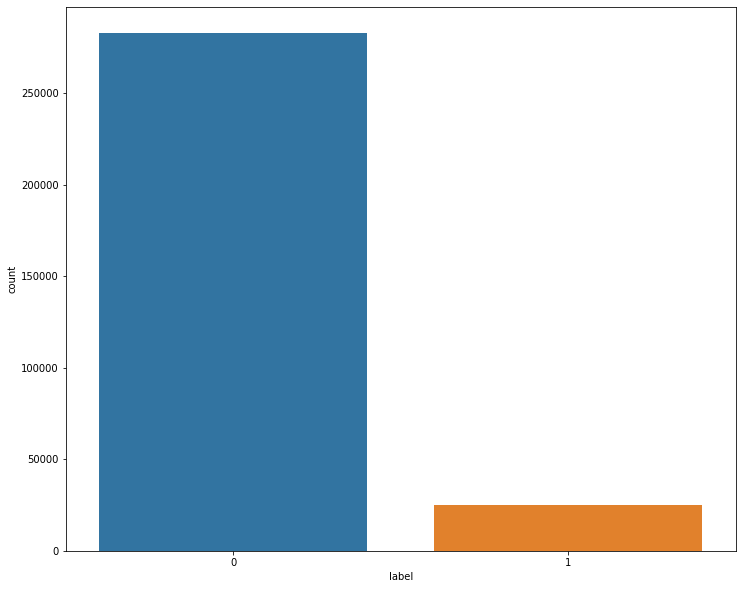

In [18]:
df_pd = new_df.toPandas()

plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)


## Total number of Categorical and Numerical data

In [19]:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')

16  categorical features


In [20]:
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [21]:
#numerical columns
num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')


104  numerical features


In [22]:
num_cols

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXP

## Counting Missing Values

In [23]:
def info_missing_table(df_pd):
    mis_val = df_pd.isnull().sum()
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
    
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n" 
    "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.") 
    
    return mis_val_table_ren_columns
  
    
missings = info_missing_table(df_pd)
missings
    

Your selected dataframe has 121 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


## Counting missing values in every column

In [24]:
new_df.select([count(when(col(c).isNull(), c)).alias(c) for c in new_df.columns]).toPandas().T.sort_values(0, ascending=False)


,0
COMMONAREA_AVG,214865
COMMONAREA_MODE,214865
COMMONAREA_MEDI,214865
NONLIVINGAPARTMENTS_AVG,213514
NONLIVINGAPARTMENTS_MODE,213514
...,...
REGION_POPULATION_RELATIVE,0
NAME_HOUSING_TYPE,0
NAME_FAMILY_STATUS,0
NAME_EDUCATION_TYPE,0


## Duplicate data checking

In [25]:
new_df.distinct().count()

307511

## Detecting Categorical and Numerical column

In [26]:
df = new_df.toPandas()
miss_counts = df.columns[df.isnull().any()].tolist()
miss_counts

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',

In [27]:
list_cols_miss=[x for x in miss_counts]
df_miss= new_df.select(*list_cols_miss)

#categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("cateogrical columns_miss:", catcolums_miss)

### numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numerical columns_miss:", numcolumns_miss)



cateogrical columns_miss: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
numerical columns_miss: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRA

## Filling Missing Values

In [29]:
df_Nomiss=new_df.na.drop()
for x in catcolums_miss:                  
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode) #print name of columns and it's most categories 
    
    new_df = new_df.na.fill({x:mode})
    # and we fill the missing numerical values with the average of each 
    #column
    
for i in numcolumns_miss:
    meanvalue = new_df.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue) 
    new_df=new_df.na.fill({i:meanvalue})
    

NAME_TYPE_SUITE Unaccompanied
OCCUPATION_TYPE Laborers
FONDKAPREMONT_MODE reg oper account
HOUSETYPE_MODE block of flats
WALLSMATERIAL_MODE Panel
EMERGENCYSTATE_MODE No
AMT_ANNUITY 27109.0
AMT_GOODS_PRICE 538396.0
OWN_CAR_AGE 12.0
CNT_FAM_MEMBERS 2.0
EXT_SOURCE_1 1.0
EXT_SOURCE_2 1.0
EXT_SOURCE_3 1.0
APARTMENTS_AVG 0.0
BASEMENTAREA_AVG 0.0
YEARS_BEGINEXPLUATATION_AVG 1.0
YEARS_BUILD_AVG 1.0
COMMONAREA_AVG 0.0
ELEVATORS_AVG 0.0
ENTRANCES_AVG 0.0
FLOORSMAX_AVG 0.0
FLOORSMIN_AVG 0.0
LANDAREA_AVG 0.0
LIVINGAPARTMENTS_AVG 0.0
LIVINGAREA_AVG 0.0
NONLIVINGAPARTMENTS_AVG 0.0
NONLIVINGAREA_AVG 0.0
APARTMENTS_MODE 0.0
BASEMENTAREA_MODE 0.0
YEARS_BEGINEXPLUATATION_MODE 1.0
YEARS_BUILD_MODE 1.0
COMMONAREA_MODE 0.0
ELEVATORS_MODE 0.0
ENTRANCES_MODE 0.0
FLOORSMAX_MODE 0.0
FLOORSMIN_MODE 0.0
LANDAREA_MODE 0.0
LIVINGAPARTMENTS_MODE 0.0
LIVINGAREA_MODE 0.0
NONLIVINGAPARTMENTS_MODE 0.0
NONLIVINGAREA_MODE 0.0
APARTMENTS_MEDI 0.0
BASEMENTAREA_MEDI 0.0
YEARS_BEGINEXPLUATATION_MEDI 1.0
YEARS_BUILD_MEDI 1.0


## checking missing value again

In [30]:
new_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in new_df.columns)).show()


+-----+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+---------------+

## Encoding

In [32]:
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
    

In [33]:
stages

[StringIndexer_0326b12573ae,
 OneHotEncoder_1249f49601aa,
 StringIndexer_4c2a651e9608,
 OneHotEncoder_eda2c4bef371,
 StringIndexer_208ce78a7f3f,
 OneHotEncoder_ab6c7aa01402,
 StringIndexer_1881142e6bbb,
 OneHotEncoder_23d060c9c5d3,
 StringIndexer_7d2f7c139a81,
 OneHotEncoder_944a662d1edd,
 StringIndexer_9fe10a0779b8,
 OneHotEncoder_cce7a5551e41,
 StringIndexer_3c90aca1b51c,
 OneHotEncoder_477f5fd15651,
 StringIndexer_70962ada92f2,
 OneHotEncoder_9d86a079f14c,
 StringIndexer_f17cf43753b8,
 OneHotEncoder_556ffdaf4afe,
 StringIndexer_59abb4ace763,
 OneHotEncoder_e37c30145593,
 StringIndexer_605d5535508e,
 OneHotEncoder_f8ddb17e3c1a,
 StringIndexer_99bf852fa2ef,
 OneHotEncoder_277a731a4e48,
 StringIndexer_defd1e42ecf3,
 OneHotEncoder_e6cdc89aac67,
 StringIndexer_81345d5789ba,
 OneHotEncoder_4cc92a301ffc,
 StringIndexer_9f53420627a8,
 OneHotEncoder_0fbb04400315,
 StringIndexer_9bf39c1af47c,
 OneHotEncoder_cebe6108f2de,
 VectorAssembler_5d482c9b6b5e]

## Pipeline

In [35]:
cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)

selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)
pd.DataFrame(new_df.take(5), columns=new_df.columns)


,features,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",1,Cash loans,M,N,Y,0,202500,406597.5,24700.5,351000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648,-2120,12,1,1,0,1,1,0,Laborers,1,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2,2,2,2,-1134,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,Cash loans,F,N,N,0,270000,1293502.5,35698.5,1129500,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186,-291,12,1,1,0,1,1,0,Core staff,2,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1,0,1,0,-828,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"(0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Revolving loans,M,Y,Y,0,67500,135000.0,6750.0,135000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260,-2531,26,1,1,1,1,1,0,Laborers,1,2,2,MONDAY,9,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.00,reg oper account,block of flats,0.0000,Panel,No,0,0,0,0,-815,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,F,N,Y,0,135000,312682.5,29686.5,297000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833,-2437,12,1,1,0,1,0,0,Laborers,2,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.00,reg oper account,block of flats,0.0000,Panel,No,2,0,2,0,-617,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,M,N,Y,0,121500,513000.0,21865.5,513000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311,-3458,12,1,1,0,1,0,0,Core staff,1,2,2,THURSDAY,11,0,0,0,0,1,1,...,0.0000,0.0000,0.0000,0.00,reg oper account,block of flats,0.0000,Panel,No,0,0,0,0,-1106,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Dividing Dataset

In [36]:
train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

245965
61546


## Model

In [37]:
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

In [38]:
trainingSummary = LR_model.summary
trainingSummary

## plotting the ROC Curve

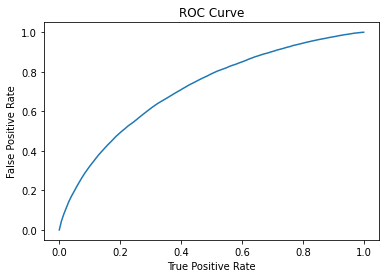

Training set ROC: 0.7144445038950614


In [40]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set ROC: ' + str(trainingSummary.areaUnderROC))


## checking model’s performance on the testing set:

In [41]:
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))


Test_SET (Area Under ROC): 0.7237657554381305


## Training with Gradient Boosting Trees

#### Model

In [43]:
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)


#### checking model’s performance on the testing set:

In [45]:
gbt_predictions = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))


Test_SET (Area Under ROC): 0.7384162452581505


#### Hyperparameter Tuning

In [48]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 30])
             .addGrid(gbt.maxIter, [10, 15])
             .build())


In [49]:
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [50]:
cvModel = cv.fit(train)
gbt_cv_predictions = cvModel.transform(test)
evaluator.evaluate(gbt_cv_predictions)


0.7421587092788171